# SOCCER ANALYTICS

#### Prueba técnica de Álvaro Huete Oliva

## Objetivo

En este ejercicio se intenta predecir el **resultado final** de una muestra de partidos de fútbol de las principales ligas europeas. Para ello, contamos con una muestra de 14,000 partidos ocurridos en un período de 10 años de los que conocemos todos los eventos que se producen hasta el final de la primera parte del encuentro. Además, conocemos el resultado final para un conjunto de 13,000 encuentros. Nos encontramos por tanto ante un problema **supervisado de clasificación**.

## Importación de librerías

Importamos las librerías que vamos a utilizar durante toda la prueba:

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError, PrecisionRecallCurve, ConfusionMatrix, ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

## Lectura de datos

Cargamos los ficheros CSV y los leemos en formato Dataframe, para poder previsualizar los datos y ver qué formato y tamaño tienen:

In [2]:
train_matches = pd.read_csv('C:/Users/asus/Desktop/Fintonic/train_matches.csv')
train_matches.head()

,id_partido,temporada,id_equipo_local,id_equipo_visitante,id_jugador_local_1,id_jugador_local_2,id_jugador_local_3,id_jugador_local_4,id_jugador_local_5,id_jugador_local_6,...,id_jugador_visitante_3,id_jugador_visitante_4,id_jugador_visitante_5,id_jugador_visitante_6,id_jugador_visitante_7,id_jugador_visitante_8,id_jugador_visitante_9,id_jugador_visitante_10,id_jugador_visitante_11,ganador
0,1,0,1,2,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,0
1,2,0,3,4,23,24,25,26,27,28,...,36,37,38,39,40,41,42,43,44,1
2,3,0,5,6,45,46,47,48,49,50,...,58,59,60,61,62,63,64,65,66,2
3,4,0,7,8,67,68,69,70,71,72,...,80,81,82,83,84,85,86,87,88,1
4,5,0,9,10,89,90,91,92,93,94,...,102,0,104,105,106,107,108,109,110,1


In [3]:
train_matches.shape[0]

13000

In [4]:
test_matches = pd.read_csv('C:/Users/asus/Desktop/Fintonic/test_matches.csv')

In [5]:
events = pd.read_csv('C:/Users/asus/Desktop/Fintonic/events.csv')
events.head()

,evento,subtipo,subtipo2,id_jugador_1,id_jugador_2,id_equipo,lat,lon,minuto,minuto_descuento,id_partido
0,GOL,NaN,NaN,7,-1,1,NaN,NaN,12,NaN,1
1,GOL,NaN,NaN,11,-1,1,NaN,NaN,16,NaN,1
2,GOL,NaN,NaN,21,-1,2,NaN,NaN,25,NaN,1
3,TARJETA AMARILLA,NaN,y,17,-1,2,NaN,NaN,19,NaN,1
4,TARJETA AMARILLA,NaN,y,21,-1,2,NaN,NaN,44,NaN,1


Veamos el tipo de cada variables y cuántos registros nulos contiene:

In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415805 entries, 0 to 415804
Data columns (total 11 columns):
evento              415805 non-null object
subtipo             342222 non-null object
subtipo2            22287 non-null object
id_jugador_1        415805 non-null int64
id_jugador_2        415805 non-null int64
id_equipo           415805 non-null int64
lat                 174228 non-null float64
lon                 174228 non-null float64
minuto              415805 non-null int64
minuto_descuento    14992 non-null float64
id_partido          415805 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


Frecuencia de cada evento:

In [7]:
events.groupby('evento').size()

evento
CENTRO                                 114937
CENTRO DE SAQUE DE BANDA                 4018
CORNER                                  62238
FALTA                                  106908
GOL                                     17038
GOL ANULADO                               264
PENALTY FUERA                               1
PENALTY PARADO                            309
PENALTY REPETIDO                            7
SEGUNDA TARJETA AMARILLA AL JUGADOR       244
TARJETA AMARILLA                        21533
TARJETA ROJA                              510
TIRO A PORTERIA                         43270
TIRO FUERA                              44528
dtype: int64

Veamos cómo se distribuyen las proporciones para cada resultado posible:

In [8]:
t1 = (train_matches.groupby('ganador').size()/train_matches.shape[0]).reset_index()
t1.iloc[:,1]*100

0    25.238462
1    46.546154
2    28.215385
Name: 0, dtype: float64

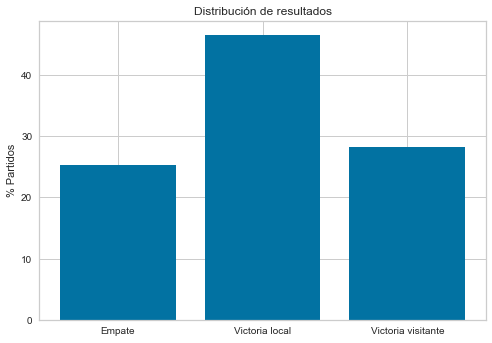

In [9]:
x=['Victoria local','Victoria visitante','Empate']
y = [t1.iloc[1,1]*100, t1.iloc[2,1]*100, t1.iloc[0,1]*100]
plt.bar(x, y)
plt.ylabel('% Partidos')
plt.title('Distribución de resultados')
plt.show()

Podemos observar que el **46.5%** de los encuentros los gana el **equipo local**, 28.2% el equipo visitante y el 25.2% terminan en empate.

A continuación vamos a crear las variables que utilizaremos para nuestro modelo predictivo. Utilizaremos el dataframe de Eventos para obtener información de cada encuentro, así como datos históricos tanto para el equipo local como para el equipo visitante. Seleccionamos únicamente las variables que nos vayan a ser de utilidad para este modelo:

In [10]:
events2 = events[['evento', 'subtipo', 'id_equipo', 'minuto', 'minuto_descuento', 'id_partido']]

In [11]:
df_train = train_matches[['id_partido', 'temporada', 'id_equipo_local', 'id_equipo_visitante', 'ganador']]

## Feature Engineering

Utilizando el dataframe de eventos, podemos agrupar por partido y equipo datos que aportan información útil sobre el desarrollo del encuentro para que nos ayuden a estimar cuál será el resultado final.
Además se tratan los datos nulos y datos atípicos para evitar que alteren los resultados del modelo.

### Goles anotados por cada equipo 

Para cada partido calculamos los goles que ha anotado cada equipo antes del descanso, y por tanto qué equipo va ganando al finalizar la primera parte y cuál es la diferencia de goles.

In [12]:
goles = events2[events2.evento=='GOL'].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='goles')

In [13]:
df_goles_local = df_train.merge(
    goles, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_goles_local = df_goles_local.rename(columns={'goles':'goles_local'})
df_goles_visitante = df_train.merge(
    goles, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_goles_visitante = df_goles_visitante.rename(columns={'goles':'goles_visitante'})
df_goles = df_goles_local[['id_partido', 'temporada', 'goles_local']].merge(
    df_goles_visitante[['id_partido', 'goles_visitante', 'ganador']], 
    how='inner', 
    on='id_partido')
df_goles = df_goles.fillna(0) # Rellenamos los datos nulos con 0's, puesto que se trata de equipos 
                              # que no han anotado ningún gol. Análogamente para el resto de variables.

In [14]:
df_goles['ganador_descanso'] = df_goles.apply(
    lambda x: 1 if x['goles_local']>x['goles_visitante'] 
    else (2 if x['goles_local']<x['goles_visitante'] 
          else 0), axis=1)
df_goles['diferencia_goles'] = df_goles['goles_local']-df_goles['goles_visitante']

###  Centros por equipo

Centros y centros de saque de banda para cada equipo.

In [15]:
centros = events2[events2.evento.isin(['CENTRO', 'CENTRO DE SAQUE DE BANDA'])].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='centros')

In [16]:
df_centros_local = df_train.merge(
    centros, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_centros_local = df_centros_local.rename(columns={'centros':'centros_local'})
df_centros_visitante = df_train.merge(
    centros, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_centros_visitante = df_centros_visitante.rename(columns={'centros':'centros_visitante'})
df_centros = df_centros_local[['id_partido', 'centros_local']].merge(
    df_centros_visitante[['id_partido', 'centros_visitante']], 
    how='inner', 
    on='id_partido')
df_centros = df_centros.fillna(0)

### Faltas de cada equipo

Calculamos el numero de faltas cometidas por ambos equipos.

In [17]:
faltas = events2[events2.evento=='FALTA'].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='faltas')

In [18]:
df_faltas_local = df_train.merge(
    faltas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_faltas_local = df_faltas_local.rename(columns={'faltas':'faltas_local'})
df_faltas_visitante = df_train.merge(
    faltas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_faltas_visitante = df_faltas_visitante.rename(columns={'faltas':'faltas_visitante'})
df_faltas = df_faltas_local[['id_partido', 'faltas_local']].merge(
    df_faltas_visitante[['id_partido', 'faltas_visitante']], 
    how='inner', 
    on='id_partido')
df_faltas = df_faltas.fillna(0)

### Tiros a porteria

In [19]:
tiros_porteria = events2[events2.evento=='TIRO A PORTERIA'].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='tiros_porteria')

In [20]:
df_tiros_porteria_local = df_train.merge(
    tiros_porteria, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_tiros_porteria_local = df_tiros_porteria_local.rename(
    columns={'tiros_porteria':'tiros_porteria_local'})
df_tiros_porteria_visitante = df_train.merge(
    tiros_porteria, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_tiros_porteria_visitante = df_tiros_porteria_visitante.rename(
    columns={'tiros_porteria':'tiros_porteria_visitante'})
df_tiros_porteria = df_tiros_porteria_local[['id_partido', 'tiros_porteria_local']].merge(
    df_tiros_porteria_visitante[['id_partido', 'tiros_porteria_visitante']], 
    how='inner', 
    on='id_partido')
df_tiros_porteria = df_tiros_porteria.fillna(0)

### Tiros fuera

In [21]:
tiros_fuera = events2[events2.evento=='TIRO FUERA'].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='tiros_fuera')

In [22]:
df_tiros_fuera_local = df_train.merge(
    tiros_fuera, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_tiros_fuera_local = df_tiros_fuera_local.rename(
    columns={'tiros_fuera':'tiros_fuera_local'})
df_tiros_fuera_visitante = df_train.merge(
    tiros_fuera, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_tiros_fuera_visitante = df_tiros_fuera_visitante.rename(
    columns={'tiros_fuera':'tiros_fuera_visitante'})
df_tiros_fuera = df_tiros_fuera_local[['id_partido', 'tiros_fuera_local']].merge(
    df_tiros_fuera_visitante[['id_partido', 'tiros_fuera_visitante']], 
    how='inner', 
    on='id_partido')
df_tiros_fuera = df_tiros_fuera.fillna(0)

### Tarjetas amarillas de cada equipo

In [23]:
amarillas = events2[events2.evento=='TARJETA AMARILLA'].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='amarillas')

In [24]:
df_amarillas_local = df_train.merge(
    amarillas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])

df_amarillas_local = df_amarillas_local.rename(columns={'amarillas':'amarillas_local'})
df_amarillas_visitante = df_train.merge(
    amarillas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_amarillas_visitante = df_amarillas_visitante.rename(columns={'amarillas':'amarillas_visitante'})
df_amarillas = df_amarillas_local[['id_partido', 'amarillas_local']].merge(
    df_amarillas_visitante[['id_partido', 'amarillas_visitante']], 
    how='inner', 
    on='id_partido')
df_amarillas = df_amarillas.fillna(0)

### Expulsiones de cada equipo

Para cada equipo de contabilizan las tarjetas rojas y las segundas tarjetas amarillas.

In [25]:
rojas = events2[events2.evento.isin(['TARJETA ROJA', 'SEGUNDA TARJETA AMARILLA AL JUGADOR'])].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='rojas')

In [26]:
df_rojas_local = df_train.merge(
    rojas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_rojas_local = df_rojas_local.rename(columns={'rojas':'rojas_local'})
df_rojas_visitante = df_train.merge(
    rojas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_rojas_visitante = df_rojas_visitante.rename(columns={'rojas':'rojas_visitante'})
df_rojas = df_rojas_local[['id_partido', 'rojas_local']].merge(
    df_rojas_visitante[['id_partido', 'rojas_visitante']], 
    how='inner', 
    on='id_partido')
df_rojas = df_rojas.fillna(0)

### Corners

In [27]:
corners = events2[events2.evento=='CORNER'].groupby(
    ['id_partido', 'id_equipo']).size().reset_index(name='corners')

In [28]:
df_corners_local = df_train.merge(
    corners, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_corners_local = df_corners_local.rename(columns={'corners':'corners_local'})
df_corners_visitante = df_train.merge(
    corners, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_corners_visitante = df_corners_visitante.rename(columns={'corners':'corners_visitante'})
df_corners = df_corners_local[['id_partido', 'corners_local']].merge(
    df_corners_visitante[['id_partido', 'corners_visitante']], 
    how='inner', 
    on='id_partido')
df_corners = df_corners.fillna(0)

### Resultados históricos equipos locales

Para cada equipo local se calcula la ratio de victorias, derrotas y empates en todas las temporadas.

In [29]:
partidos_local = df_train.groupby('id_equipo_local').size().reset_index(name='partidos_local')
victorias_local = df_train[df_train.ganador==1].groupby('id_equipo_local').size().reset_index(name='victorias_local')
derrotas_local = df_train[df_train.ganador==2].groupby('id_equipo_local').size().reset_index(name='derrotas_local')
empates_local = df_train[df_train.ganador==0].groupby('id_equipo_local').size().reset_index(name='empates_local')
historico_local = partidos_local.merge(victorias_local, how='inner', on='id_equipo_local')
historico_local = historico_local.merge(derrotas_local, how='inner', on='id_equipo_local')
historico_local = historico_local.merge(empates_local, how='inner', on='id_equipo_local')
historico_local['ratio_victorias_local'] = historico_local['victorias_local']/historico_local['partidos_local']
historico_local['ratio_derrotas_local'] = historico_local['derrotas_local']/historico_local['partidos_local']
historico_local['ratio_empates_local'] = historico_local['empates_local']/historico_local['partidos_local']

### Resultados históricos equipos visitantes

Se procede de forma análoga al caso anterior

In [30]:
partidos_visitante = df_train.groupby('id_equipo_visitante').size().reset_index(name='partidos_visitante')
victorias_visitante = df_train[df_train.ganador==2].groupby('id_equipo_visitante').size().reset_index(name='victorias_visitante')
derrotas_visitante = df_train[df_train.ganador==1].groupby('id_equipo_visitante').size().reset_index(name='derrotas_visitante')
empates_visitante = df_train[df_train.ganador==0].groupby('id_equipo_visitante').size().reset_index(name='empates_visitante')
historico_visitante = partidos_visitante.merge(victorias_visitante, how='inner', on='id_equipo_visitante')
historico_visitante = historico_visitante.merge(derrotas_visitante, how='inner', on='id_equipo_visitante')
historico_visitante = historico_visitante.merge(empates_visitante, how='inner', on='id_equipo_visitante')
historico_visitante['ratio_victorias_visitante'] = historico_visitante['victorias_visitante']/historico_visitante['partidos_visitante']
historico_visitante['ratio_derrotas_visitante'] = historico_visitante['derrotas_visitante']/historico_visitante['partidos_visitante']
historico_visitante['ratio_empates_visitante'] = historico_visitante['empates_visitante']/historico_visitante['partidos_visitante']

### Media de goles

Para cada equipo de calcula cuántos goles anota de media en cada partido, utilizando los partidos de todas las temporadas.

In [31]:
k1 = events2[events2.evento=='GOL'].groupby(
    ['id_equipo', 'id_partido']).agg({'evento':'count'}).reset_index()

In [32]:
k2 = k1.groupby('id_equipo').agg(
    {'evento':'mean'}).reset_index().rename(columns={'evento':'media_goles'})
k2.head()

,id_equipo,media_goles
0,-1,1.055556
1,1,1.591716
2,2,1.258065
3,3,1.464706
4,4,1.250000


### Media de tiros a porteria

Tiros a portería realizados de media por cada equipo a lo largo de todas las temporadas.

In [33]:
t1 = events2[events2.evento=='TIRO A PORTERIA'].groupby(
    ['id_equipo', 'id_partido']).agg({'evento':'count'}).reset_index()

In [34]:
t2 = t1.groupby('id_equipo').agg(
    {'evento':'mean'}).reset_index().rename(columns={'evento':'media_tiros_porteria'})
t2.head()

,id_equipo,media_tiros_porteria
0,-1,1.000000
1,1,3.475000
2,2,2.350877
3,3,3.654545
4,4,2.641921


### Media de centros

Cuántos centros ejecuta cada equipo de media por partido.

In [35]:
c1 = events2[events2.evento=='CENTRO'].groupby(
    ['id_equipo', 'id_partido']).agg({'evento':'count'}).reset_index()

In [36]:
c2 = c1.groupby('id_equipo').agg(
    {'evento':'mean'}).reset_index().rename(columns={'evento':'media_centros'})
c2.head()

,id_equipo,media_centros
0,-1,1.096154
1,1,8.023952
2,2,6.146154
3,3,8.147157
4,4,6.369650


### Minuto del primer gol

Para cada partido se calcula en qué minuto marca el primer gol cada equipo.

In [37]:
m1 = events2[events2.evento=='GOL'].groupby(['id_partido', 'id_equipo']).agg(
    {'minuto':'min'}).reset_index().rename(columns={'minuto':'min_primer_gol'})
m1.head()

,id_partido,id_equipo,min_primer_gol
0,1,1,12
1,1,2,25
2,2,3,4
3,4,7,4
4,5,9,2


## Creación del dataframe

A continuación, unimos todas las variables en un único dataframe que será utilizado por el modelo para hacer las predicciones.

In [38]:
X = df_goles.merge(df_centros, how='inner', on='id_partido')
X = X.merge(df_faltas, how='inner', on='id_partido')
X = X.merge(df_tiros_porteria, how='inner', on='id_partido')
X = X.merge(df_tiros_fuera, how='inner', on='id_partido')
X = X.merge(df_amarillas, how='inner', on='id_partido')
X = X.merge(df_rojas, how='inner', on='id_partido')
X = X.merge(df_corners, how='inner', on='id_partido')
X = X.merge(df_train[['id_partido', 'id_equipo_local', 'id_equipo_visitante']], how='left', on='id_partido')
X = X.merge(historico_local[['ratio_victorias_local', 'ratio_derrotas_local', 'ratio_empates_local', 'id_equipo_local']],
            how='left', on='id_equipo_local')
X = X.merge(historico_visitante[['ratio_victorias_visitante', 'ratio_derrotas_visitante', 'ratio_empates_visitante', 'id_equipo_visitante']],
            how='left', on='id_equipo_visitante')
X = X.merge(k2, how='left', left_on='id_equipo_local', right_on='id_equipo')
X = X.rename(columns={'media_goles':'media_goles_local'})
X = X.drop(columns='id_equipo')
X = X.merge(k2, how='left', left_on='id_equipo_visitante', right_on='id_equipo')
X = X.rename(columns={'media_goles':'media_goles_visitante'})
X = X.drop(columns='id_equipo')
X = X.merge(t2, how='left', left_on='id_equipo_local', right_on='id_equipo')
X = X.rename(columns={'media_tiros_porteria':'media_tiros_porteria_local'})
X = X.drop(columns='id_equipo')
X = X.merge(t2, how='left', left_on='id_equipo_visitante', right_on='id_equipo')
X = X.rename(columns={'media_tiros_porteria':'media_tiros_porteria_visitante'})
X = X.drop(columns='id_equipo')
X = X.merge(c2, how='left', left_on='id_equipo_local', right_on='id_equipo')
X = X.rename(columns={'media_centros':'media_centros_local'})
X = X.drop(columns='id_equipo')
X = X.merge(c2, how='left', left_on='id_equipo_visitante', right_on='id_equipo')
X = X.rename(columns={'media_centros':'media_centros_visitante'})
X = X.drop(columns='id_equipo')
X = X.merge(m1, 
            how='left', 
            left_on=['id_partido', 'id_equipo_local'], 
            right_on=['id_partido', 'id_equipo'])
X = X.rename(columns={'min_primer_gol':'min_primer_gol_local'})
X = X.drop(columns='id_equipo')
X = X.merge(m1, 
            how='left', 
            left_on=['id_partido', 'id_equipo_visitante'], 
            right_on=['id_partido', 'id_equipo'])
X = X.rename(columns={'min_primer_gol':'min_primer_gol_visitante'})
X = X.drop(columns='id_equipo')

Los datos **nulos** de ratios y medias los rellenamos con **ceros**, mientras que los registros de minutos sin datos los sustituimos por **999**, para indicar que no se ha marcado ningún gol.

In [39]:
X[['ratio_victorias_local', 'ratio_derrotas_local', 'ratio_empates_local', 'ratio_victorias_visitante', 'ratio_derrotas_visitante', 'ratio_empates_visitante', 'media_goles_local', 'media_goles_visitante', 'media_tiros_porteria_local', 'media_tiros_porteria_visitante', 'media_centros_local', 'media_centros_visitante']] = X[['ratio_victorias_local', 'ratio_derrotas_local', 'ratio_empates_local', 'ratio_victorias_visitante', 'ratio_derrotas_visitante', 'ratio_empates_visitante', 'media_goles_local', 'media_goles_visitante', 'media_tiros_porteria_local', 'media_tiros_porteria_visitante', 'media_centros_local', 'media_centros_visitante']].fillna(0)
X[['min_primer_gol_local', 'min_primer_gol_visitante']] = X[['min_primer_gol_local', 'min_primer_gol_visitante']].fillna(999)

En este caso, no tiene sentido buscar outliers puesto que las variables son agrupaciones que hemos realizado nosotros. En otro caso, se consideraría como outliers aquellos datos mayores que Q3 + 1.5x(Q3-Q1). Podemos comprobar la distribución de las variables para ver si hay datos atípicos:

In [40]:
X.describe()

,id_partido,temporada,goles_local,goles_visitante,ganador,ganador_descanso,diferencia_goles,centros_local,centros_visitante,faltas_local,...,ratio_derrotas_visitante,ratio_empates_visitante,media_goles_local,media_goles_visitante,media_tiros_porteria_local,media_tiros_porteria_visitante,media_centros_local,media_centros_visitante,min_primer_gol_local,min_primer_gol_visitante
count,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,...,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000
mean,6511.563462,3.530846,0.691615,0.508692,1.029769,0.813077,0.182923,4.454538,3.392231,3.492923,...,0.463077,0.251538,1.324377,1.324903,2.706536,2.707374,6.531324,6.533274,512.652231,612.926308
std,3760.835765,2.173164,0.836356,0.722258,0.730543,0.783503,1.119418,4.969026,3.978721,3.676881,...,0.131530,0.054433,0.121029,0.120508,0.639581,0.639468,1.565393,1.565826,488.550588,477.277118
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3253.750000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.356643,0.225352,1.245902,1.245902,2.444444,2.444444,5.984615,5.984615,21.000000,29.000000
50%,6512.500000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,3.000000,...,0.490385,0.250000,1.320312,1.321429,2.727273,2.730769,6.743590,6.743590,999.000000,999.000000
75%,9770.250000,5.000000,1.000000,1.000000,2.000000,1.000000,1.000000,8.000000,6.000000,6.000000,...,0.553571,0.276596,1.375940,1.375940,2.986111,2.986111,7.383333,7.383333,999.000000,999.000000
max,13021.000000,7.000000,6.000000,6.000000,2.000000,2.000000,6.000000,40.000000,24.000000,19.000000,...,0.842105,0.470588,2.000000,2.000000,5.000000,5.000000,12.000000,12.000000,999.000000,999.000000


## Análisis exploratorio

A continuación, vamos a realizar un análisis exploratorio de las variables para estudiar la distribución de los datos y poder extraer algunas conclusiones sobre ellos y poder analizar el comportamiento de las mismas atendiento a diferentes factores, como el equipo, la temporada, etc.

In [72]:
datos = df_train[['id_partido', 'temporada', 'ganador']].merge(
    events2[['id_partido', 'evento', 'subtipo']], how='inner', on='id_partido')

Veamos como se distribuyen los resultado finales a lo largo de todas las temporadas:

In [80]:
s1 = pd.crosstab(df_train.temporada, df_train.ganador)

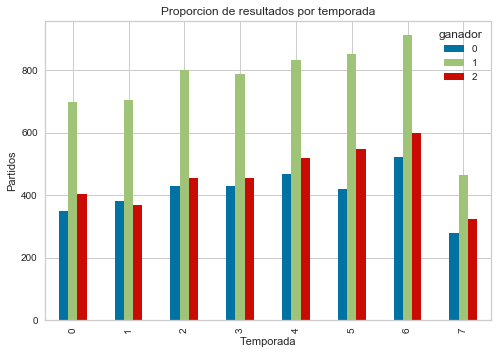

In [82]:
s1.plot.bar()
plt.ylabel('Partidos')
plt.xlabel('Temporada')
plt.title('Proporcion de resultados por temporada')
plt.show()

En todas las temporadas hay un mayor número de victorias locales, y solo en la temporada 1 hay más empates que victorias visitantes.

In [75]:
s2 = datos.loc[(datos.evento=='FALTA')&(datos.subtipo=='PENALTY')].groupby(
    ['temporada']).agg({'evento':'count'})

También podemos analizar la frecuencia de eventos en cada temporada, por ejemplo, veamos el número de penalties registrados en cada temporada:

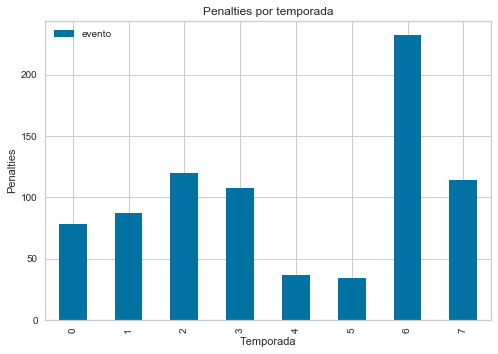

In [76]:
s2.plot.bar()
plt.ylabel('Penalties')
plt.xlabel('Temporada')
plt.title('Penalties por temporada')
plt.show()

Mediante gráficos box-plot podemos analizar la evolución a lo largo del tiempo de algunas variables. Veamos cómo evoluciona el ratio de derrotas del equipo local:

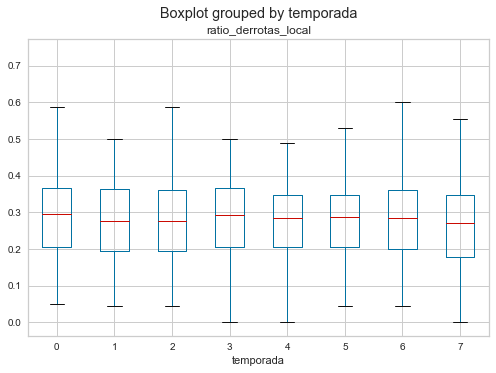

In [78]:
X.boxplot(column=['ratio_derrotas_local'], by='temporada')
plt.show()

Y el número medio de centros que realiza el equipo visitante, donde observamos un incremento en la media:

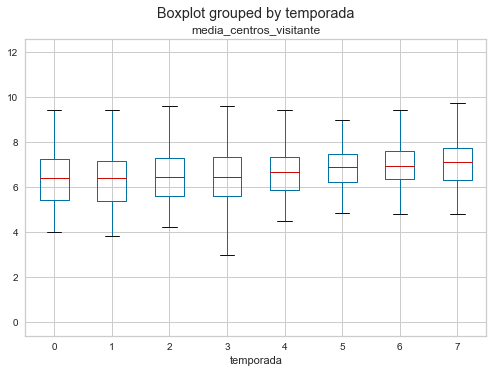

In [148]:
X.boxplot(column=['media_centros_visitante'], by='temporada')
plt.show()

También es interesante analizar la densidad de probabilidad de algunas variables para cada resultado.

Veamos la distribución de probabilidad de la variable que nos indica el minuto del primer gol local para cada uno de los resultados:

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


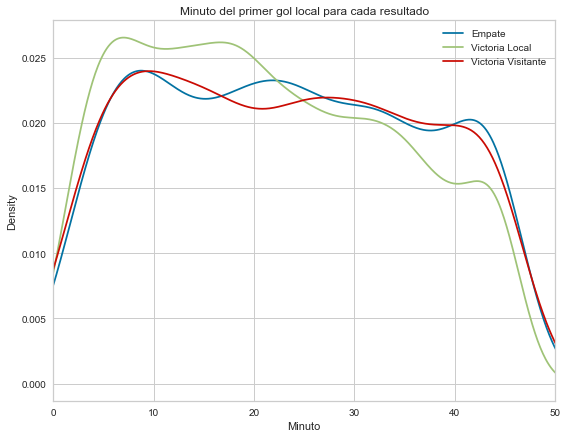

In [41]:
resultados=[0,1,2]
fig = plt.figure(figsize=(9,7))

for resultado in resultados:
    X.loc[X.ganador==resultado][X.min_primer_gol_local<100].min_primer_gol_local.plot(kind='kde')
plt.legend(('Empate', 'Victoria Local', 'Victoria Visitante'), loc=0)
plt.xlabel('Minuto')
plt.ylabel('Density')
plt.grid(True)
plt.title('Minuto del primer gol local para cada resultado')
plt.xlim(0, 50)
plt.show()

Se puede observar que la victoria local es más probable cuando el equipo local anota un tanto antes del minuto 20.

Veamos si influye en el resultado final el ratio de victorias del equipo local:

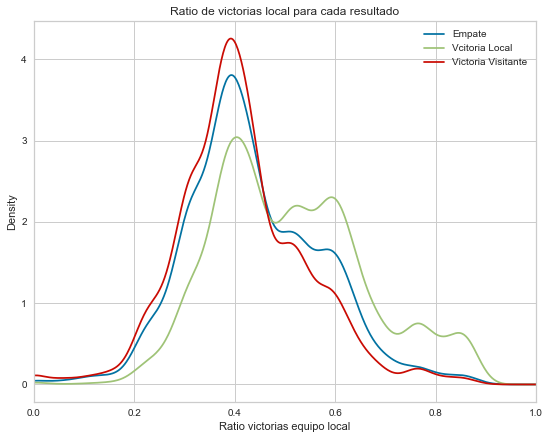

In [42]:
resultados=[0,1,2]
fig = plt.figure(figsize=(9,7))

for resultado in resultados:
    X.loc[X.ganador==resultado].ratio_victorias_local.plot(kind='kde')
plt.legend(('Empate', 'Vcitoria Local', 'Victoria Visitante'), loc=0)
plt.xlabel('Ratio victorias equipo local')
plt.ylabel('Density')
plt.grid(True)
plt.title('Ratio de victorias local para cada resultado')
plt.xlim(0, 1)
plt.show()

Se aprecia un incremento de la probabilidad de victoria local cuando el ratio es mayor que 0.5

Por último podemos ver la distribución de media de goles del equipo visitante para cada resultado:

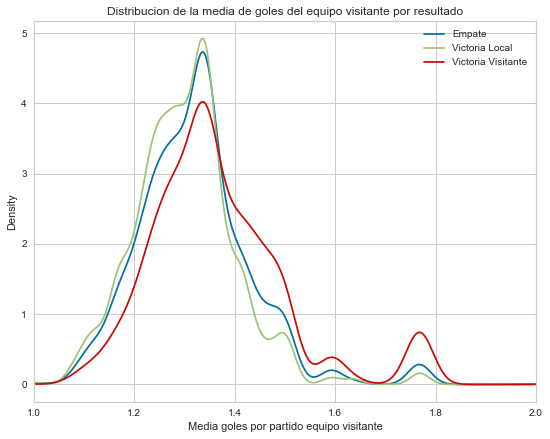

In [83]:
resultados=[0,1,2]
fig = plt.figure(figsize=(9,7))

for resultado in resultados:
    X.loc[X.ganador==resultado].media_goles_visitante.plot(kind='kde')
plt.legend(('Empate', 'Victoria Local', 'Victoria Visitante'), loc=0)
plt.xlabel('Media goles por partido equipo visitante')
plt.ylabel('Density')
plt.grid(True)
plt.title('Distribucion de la media de goles del equipo visitante por resultado')
plt.xlim(1, 2)
plt.show()

La probabilidad de victoria visitante es mayor cuando la media de goles del equipo visitante es mayor que 1.4

Otro paso importante es representar la **matriz de correlación** entre variables, para ver si existe variables correlacionadas entre sí y poder prescindir así de alguna de ellas:

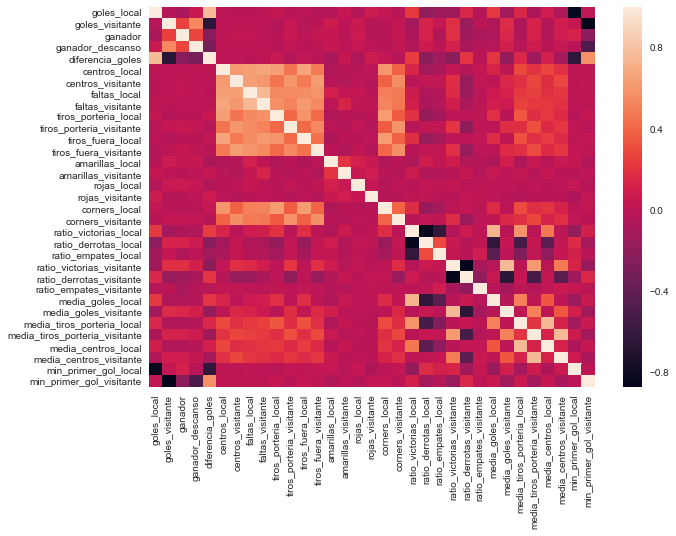

In [149]:
plt.figure(figsize=(10,7))
sns.heatmap(X.drop(columns=['id_partido', 'temporada', 'id_equipo_local', 'id_equipo_visitante']).corr())
plt.show()

## Random Forest Classifier

Por último, vamos a definir nuestro modelo predictivo. Utilizaremos un  modelo **Random Forest** para la predicción de la variable multilabel ganador.

En primer lugar, dividimos nuestro dataset en conjuntos de **train (80%), validación (10%) y test (10%)**, suprimiendo las variables que no tiene sentido considerar:

In [ ]:
X_train = X.drop(columns=['id_partido', 'temporada', 'ganador']).values
y_train = X['ganador'].values
X_test = Y.drop(columns=['id_partido']).values

In [118]:
X_valid = X.sample(frac=.1, random_state=42)
y_valid = X_valid['ganador']
X2 = X[~X.id_partido.isin(X_valid.id_partido.unique())]
X_test = X2.sample(frac=.1, random_state=42)
y_test = X_test['ganador']
X_train = X2[~X2.id_partido.isin(X_test.id_partido.unique())]
y_train = X_train['ganador']
X2_valid = X_valid.drop(columns=['id_partido', 'temporada', 'ganador', 'id_equipo_local', 'id_equipo_visitante']).values
y2_valid = y_valid.values
X2_train = X_train.drop(columns=['id_partido', 'temporada', 'ganador', 'id_equipo_local', 'id_equipo_visitante']).values
y2_train = y_train.values
X2_test = X_test.drop(columns=['id_partido', 'temporada', 'ganador', 'id_equipo_local', 'id_equipo_visitante']).values
y2_test = y_test.values

Instanciamos el modelo sin especificar ningún hiperparámetro.

In [119]:
clf = RandomForestClassifier()

Vamos a realiazar una **búsqueda aleatorizada**  en un mallado de hiperparámetros posibles del Random Forest para buscar la **combinación óptima** utilizando el subconjunto de **validación**:

In [120]:
param_grid = {
        'max_depth': [5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy'],
        'n_estimators': [100, 200, 400],
        }

In [121]:
fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X2_valid, y2_valid)]}

Definimos los parámetros de la búsqueda, realizaremos **30 iteraciones** con una configuración de **5-fold para cross-validation**, especificando la métrica que se quiere optimizar, en este caso **F1-score micro**:

In [122]:
rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=30,
                            n_jobs=1, cv=5, 
                            param_distributions=fit_params,
                            scoring='f1_micro', refit=False, random_state=42)

In [123]:
rs_clf.fit(X2_train, y2_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, refit=False, scoring='f1_micro')

Una vez finalizada la búsqueda, podemos obtener los parámetros óptimos y el mejor score:

In [124]:
rs_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [125]:
rs_clf.best_score_

0.62402659069325739

Entrenamos el modelo con los parámetros obtenidos anteriormente:

In [145]:
clf = RandomForestClassifier(
    criterion='entropy', max_depth=10, 
    min_samples_leaf=1, min_samples_split=10,
    n_estimators=200, class_weight='balanced')

clf.fit(X2_train, y2_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_split=10, n_estimators=200)

Balance para cada clase del conjunto de entrenamiento:

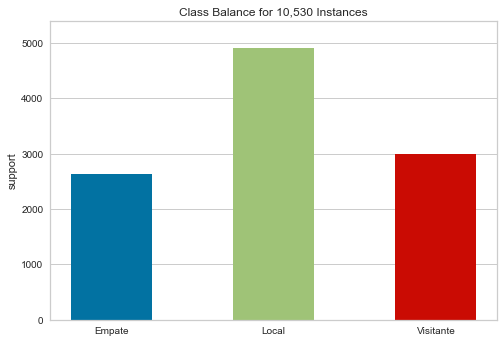

In [126]:
visualizer = ClassBalance(labels=["Empate", "Local", "Visitante"])
visualizer.fit(y2_train)        
visualizer.show()

In [128]:
y_pred = clf.predict(X2_test)

Obtenemos la matriz de confusión y observamos que el modelo clasifica mal los empates, ya que tiende a clasificarlos como victoria local:

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


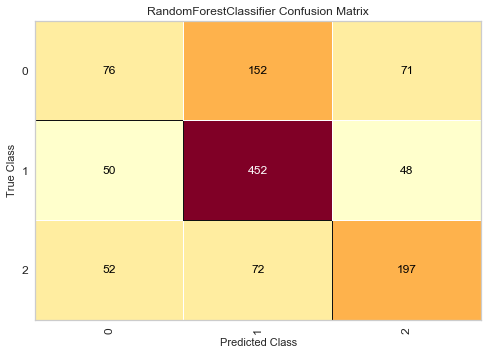

In [129]:
cm = ConfusionMatrix(clf)
cm.fit(X2_train, y2_train)
cm.score(X2_test, y2_test)
cm.show()

Calculamos las principales métricas del modelo:

In [130]:
print('Precision {:.3f}'.format(precision_score(y2_test, y_pred, average='micro')))
print('Recall {:.3f}'.format(recall_score(y2_test, y_pred, average='micro')))
print('F1_score {:.3f}'.format(f1_score(y2_test, y_pred, average='micro')))
print('Balanced accuracy: {:.3f}'.format(balanced_accuracy_score(y2_test, y_pred)))

Precision 0.620
Recall 0.620
F1_score 0.620
Balanced accuracy: 0.563


Representamos la **curva ROC** para cada clase, para ver el **trade-off** entre verdaderos positivos capturados VS falsos positivos capturados:

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


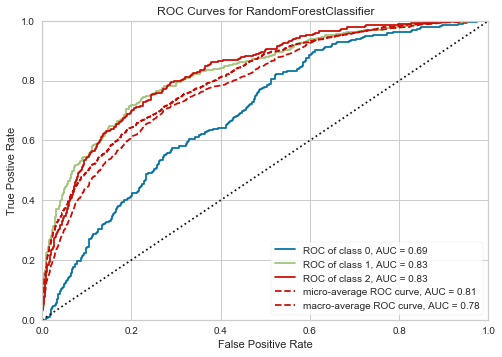

In [131]:
visualizer = ROCAUC(clf)
visualizer.fit(X2_train, y2_train)    
visualizer.score(X2_test, y2_test)        
visualizer.show()

Veamos el error de clasificación para cada clase:

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


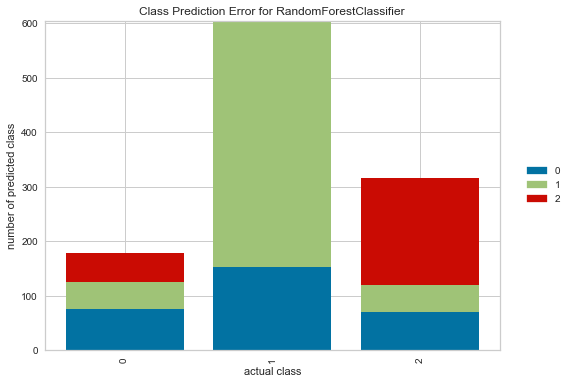

In [132]:
visualizer = ClassPredictionError(clf)
visualizer.fit(X2_train, y2_train)
visualizer.score(X2_test, y2_test)
visualizer.show()

Y finalmente representamos la importancia de cada variable en cuanto a su varianza explicada de cara a clasificar la variable objetivo:

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


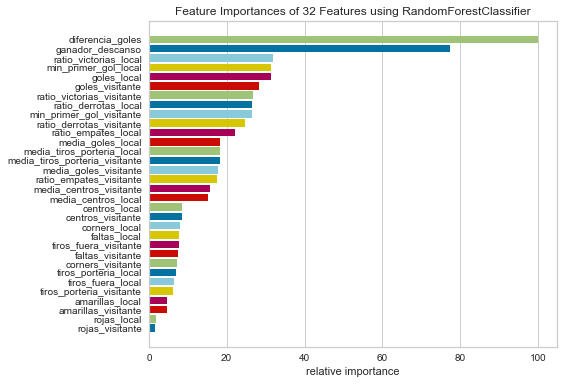

In [133]:
viz = FeatureImportances(clf)
viz.fit(X_train.drop(columns=['id_partido', 'ganador', 'temporada', 'id_equipo_local', 'id_equipo_visitante']), y_train)
viz.show()

## Conclusiones y posibles mejoras

Una vez finalizado el modelo podemos ver que tiende a clasificar de manera errónea la mayor parte de los partidos que finalizan con empate como podemos obervar en su correspondiente curva ROC. Esto puede deberse al **desbalanceo** de las clases, ya que las victorias locales poseen casi el doble de observaciones que las otras dos clases. Una de las posibles soluciones para esta casuística sería **bajomuestrear** la clase mayoritaria y entrenar el modelo con el mismo número de obervaciones para cada clase, ponderando posteriormente la clase bajomuestreada.

Además disponemos de multitud de eventos y subtipos, por lo que añadiendo nuevas variables a partir de estos eventos así como información de históricos sobre subtipos podríamos incrementar de manera significativa la métrica objetivo.

En este ejercicio se probó también un modelo de **Gradient Boosting** obteniendo unos resultados ligeramente inferiores en cuanto a la métrica elegida, por lo que se decidió finalmente implementar el modelo de Random Forest.

## Test submission

In [146]:
submission = pd.DataFrame({'id': Y['id_partido'].values, 'prediction': clf.predict(Y.drop(columns=['id_partido', 'id_equipo_local', 'id_equipo_visitante']))})
submission.to_csv('C:/Users/asus/Desktop/ultimo4.csv', index=False)

In [134]:
## Goles ##

df_test = test_matches[['id_partido', 'id_equipo_local', 'id_equipo_visitante']]
test_goles_local = df_test.merge(
    goles, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
test_goles_local = test_goles_local.rename(columns={'goles':'goles_local'})
test_goles_visitante = df_test.merge(
    goles, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
test_goles_visitante = test_goles_visitante.rename(columns={'goles':'goles_visitante'})
test_goles = test_goles_local[['id_partido', 'goles_local']].merge(
    test_goles_visitante[['id_partido', 'goles_visitante']], 
    how='inner', 
    on='id_partido')
test_goles = test_goles.fillna(0)
test_goles['ganador_descanso'] = test_goles.apply(
    lambda x: 1 if x['goles_local']>x['goles_visitante'] 
    else (2 if x['goles_local']<x['goles_visitante'] 
          else 0), axis=1)
test_goles['diferencia_goles'] = test_goles['goles_local']-test_goles['goles_visitante']


## Centros ##

test_centros_local = df_test.merge(
    centros, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
test_centros_local = test_centros_local.rename(columns={'centros':'centros_local'})
test_centros_visitante = df_test.merge(
    centros, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
test_centros_visitante = test_centros_visitante.rename(columns={'centros':'centros_visitante'})
test_centros = test_centros_local[['id_partido', 'centros_local']].merge(
    test_centros_visitante[['id_partido', 'centros_visitante']], 
    how='inner', 
    on='id_partido')
test_centros = test_centros.fillna(0)

## Faltas ##

test_faltas_local = df_test.merge(
    faltas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
test_faltas_local = test_faltas_local.rename(columns={'faltas':'faltas_local'})
test_faltas_visitante = df_test.merge(
    faltas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
test_faltas_visitante = test_faltas_visitante.rename(columns={'faltas':'faltas_visitante'})
test_faltas = test_faltas_local[['id_partido', 'faltas_local']].merge(
    test_faltas_visitante[['id_partido', 'faltas_visitante']], 
    how='inner', 
    on='id_partido')
test_faltas = test_faltas.fillna(0)

## Tiros a porteria ##

test_porteria_local = df_test.merge(
    tiros_porteria, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
test_porteria_local = test_porteria_local.rename(columns={'tiros_porteria':'porteria_local'})
test_porteria_visitante = df_test.merge(
    tiros_porteria, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
test_porteria_visitante = test_porteria_visitante.rename(columns={'tiros_porteria':'porteria_visitante'})
test_porteria = test_porteria_local[['id_partido', 'porteria_local']].merge(
    test_porteria_visitante[['id_partido', 'porteria_visitante']], 
    how='inner', 
    on='id_partido')
test_porteria = test_porteria.fillna(0)

## Tiros fuera ##

test_fuera_local = df_test.merge(
    tiros_fuera, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
test_fuera_local = test_fuera_local.rename(columns={'tiros_fuera':'fuera_local'})
test_fuera_visitante = df_test.merge(
    tiros_fuera, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
test_fuera_visitante = test_fuera_visitante.rename(columns={'tiros_fuera':'fuera_visitante'})
test_fuera = test_fuera_local[['id_partido', 'fuera_local']].merge(
    test_fuera_visitante[['id_partido', 'fuera_visitante']], 
    how='inner', 
    on='id_partido')
test_fuera = test_fuera.fillna(0)

## Tarjetas amarillas ##

df_amarillas_local = df_test.merge(
    amarillas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])

df_amarillas_local = df_amarillas_local.rename(columns={'amarillas':'amarillas_local'})
df_amarillas_visitante = df_test.merge(
    amarillas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_amarillas_visitante = df_amarillas_visitante.rename(columns={'amarillas':'amarillas_visitante'})
df_amarillas = df_amarillas_local[['id_partido', 'amarillas_local']].merge(
    df_amarillas_visitante[['id_partido', 'amarillas_visitante']], 
    how='inner', 
    on='id_partido')
df_amarillas = df_amarillas.fillna(0)

## Expulsiones ##

df_rojas_local = df_test.merge(
    rojas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_rojas_local = df_rojas_local.rename(columns={'rojas':'rojas_local'})
df_rojas_visitante = df_test.merge(
    rojas, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_rojas_visitante = df_rojas_visitante.rename(columns={'rojas':'rojas_visitante'})
df_rojas = df_rojas_local[['id_partido', 'rojas_local']].merge(
    df_rojas_visitante[['id_partido', 'rojas_visitante']], 
    how='inner', 
    on='id_partido')
df_rojas = df_rojas.fillna(0)

## Corners ##

df_corners_local = df_test.merge(
    corners, 
    how='left', 
    left_on=['id_partido', 'id_equipo_local'], 
    right_on=['id_partido', 'id_equipo'])
df_corners_local = df_corners_local.rename(columns={'corners':'corners_local'})
df_corners_visitante = df_test.merge(
    corners, 
    how='left', 
    left_on=['id_partido', 'id_equipo_visitante'], 
    right_on=['id_partido', 'id_equipo'])
df_corners_visitante = df_corners_visitante.rename(columns={'corners':'corners_visitante'})
df_corners = df_corners_local[['id_partido', 'corners_local']].merge(
    df_corners_visitante[['id_partido', 'corners_visitante']], 
    how='inner', 
    on='id_partido')
df_corners = df_corners.fillna(0)

## Historico local ##

partidos_local = df_test.groupby('id_equipo_local').size().reset_index(name='partidos_local')
victorias_local = df_train[df_train.ganador==1].groupby('id_equipo_local').size().reset_index(name='victorias_local')
derrotas_local = df_train[df_train.ganador==2].groupby('id_equipo_local').size().reset_index(name='derrotas_local')
empates_local = df_train[df_train.ganador==0].groupby('id_equipo_local').size().reset_index(name='empates_local')
historico_local = partidos_local.merge(victorias_local, how='left', on='id_equipo_local')
historico_local = historico_local.merge(derrotas_local, how='left', on='id_equipo_local')
historico_local = historico_local.merge(empates_local, how='left', on='id_equipo_local')
historico_local['ratio_victorias_local'] = historico_local['victorias_local']/historico_local['partidos_local']
historico_local['ratio_derrotas_local'] = historico_local['derrotas_local']/historico_local['partidos_local']
historico_local['ratio_empates_local'] = historico_local['empates_local']/historico_local['partidos_local']

## Historico visitante ##

partidos_visitante = df_test.groupby('id_equipo_visitante').size().reset_index(name='partidos_visitante')
victorias_visitante = df_train[df_train.ganador==2].groupby('id_equipo_visitante').size().reset_index(name='victorias_visitante')
derrotas_visitante = df_train[df_train.ganador==1].groupby('id_equipo_visitante').size().reset_index(name='derrotas_visitante')
empates_visitante = df_train[df_train.ganador==0].groupby('id_equipo_visitante').size().reset_index(name='empates_visitante')
historico_visitante = partidos_visitante.merge(victorias_visitante, how='left', on='id_equipo_visitante')
historico_visitante = historico_visitante.merge(derrotas_visitante, how='left', on='id_equipo_visitante')
historico_visitante = historico_visitante.merge(empates_visitante, how='left', on='id_equipo_visitante')
historico_visitante['ratio_victorias_visitante'] = historico_visitante['victorias_visitante']/historico_visitante['partidos_visitante']
historico_visitante['ratio_derrotas_visitante'] = historico_visitante['derrotas_visitante']/historico_visitante['partidos_visitante']
historico_visitante['ratio_empates_visitante'] = historico_visitante['empates_visitante']/historico_visitante['partidos_visitante']

In [135]:
Y = test_goles.merge(test_centros, how='inner', on='id_partido')
Y = Y.merge(test_faltas, how='inner', on='id_partido')
Y = Y.merge(test_porteria, how='inner', on='id_partido')
Y = Y.merge(test_fuera, how='inner', on='id_partido')
Y = Y.merge(df_amarillas, how='inner', on='id_partido')
Y = Y.merge(df_rojas, how='inner', on='id_partido')
Y = Y.merge(df_corners, how='inner', on='id_partido')
Y = Y.merge(df_test[['id_partido', 'id_equipo_local', 'id_equipo_visitante']], how='left', on='id_partido')
Y = Y.merge(historico_local[['ratio_victorias_local', 'ratio_derrotas_local', 'ratio_empates_local', 'id_equipo_local']],
            how='left', on='id_equipo_local')
Y = Y.merge(historico_visitante[['ratio_victorias_visitante', 'ratio_derrotas_visitante', 'ratio_empates_visitante', 'id_equipo_visitante']],
            how='left', on='id_equipo_visitante')
Y = Y.merge(k2, how='left', left_on='id_equipo_local', right_on='id_equipo')
Y = Y.rename(columns={'media_goles':'media_goles_local'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(k2, how='left', left_on='id_equipo_visitante', right_on='id_equipo')
Y = Y.rename(columns={'media_goles':'media_goles_visitante'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(t2, how='left', left_on='id_equipo_local', right_on='id_equipo')
Y = Y.rename(columns={'media_tiros_porteria':'media_tiros_porteria_local'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(t2, how='left', left_on='id_equipo_visitante', right_on='id_equipo')
Y = Y.rename(columns={'media_tiros_porteria':'media_tiros_porteria_visitante'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(c2, how='left', left_on='id_equipo_local', right_on='id_equipo')
Y = Y.rename(columns={'media_centros':'media_centros_local'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(c2, how='left', left_on='id_equipo_visitante', right_on='id_equipo')
Y = Y.rename(columns={'media_centros':'media_centros_visitante'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(m1, 
            how='left', 
            left_on=['id_partido', 'id_equipo_local'], 
            right_on=['id_partido', 'id_equipo'])
Y = Y.rename(columns={'min_primer_gol':'min_primer_gol_local'})
Y = Y.drop(columns='id_equipo')
Y = Y.merge(m1, 
            how='left', 
            left_on=['id_partido', 'id_equipo_visitante'], 
            right_on=['id_partido', 'id_equipo'])
Y = Y.rename(columns={'min_primer_gol':'min_primer_gol_visitante'})
Y = Y.drop(columns='id_equipo')


Y[['ratio_victorias_local', 'ratio_derrotas_local', 'ratio_empates_local', 'ratio_victorias_visitante', 
   'ratio_derrotas_visitante', 'ratio_empates_visitante', 'media_goles_local', 'media_goles_visitante', 
   'media_tiros_porteria_local', 'media_tiros_porteria_visitante', 'media_centros_local', 
   'media_centros_visitante']] = Y[['ratio_victorias_local', 'ratio_derrotas_local', 'ratio_empates_local', 
                                    'ratio_victorias_visitante', 'ratio_derrotas_visitante', 'ratio_empates_visitante', 
                                    'media_goles_local', 'media_goles_visitante', 'media_tiros_porteria_local', 
                                    'media_tiros_porteria_visitante', 'media_centros_local', 
                                    'media_centros_visitante']].fillna(0) 

Y[['min_primer_gol_local', 'min_primer_gol_visitante']] = Y[['min_primer_gol_local', 
                                                             'min_primer_gol_visitante']].fillna(999)